## Show some basicasad gan structureasdasd

In [41]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
%matplotlib inline


In [42]:
mnist = fetch_mldata('MNIST original', data_home="mnist/mnist")

## Load Data and print some stats yas

In [43]:
x = mnist["data"]
y = mnist["target"]

x = x.reshape(-1, 1, 28, 28)
x = x.astype(np.float32)
x /= x.max()

print("Num Samples: {}".format(x.shape[0]))
for c in range(len(set(y))):
    print("Percentage %i's: %.1f %%"%(c, len(y[y==c])/len(y)*100))

Num Samples: 70000
Percentage 0's: 9.9 %
Percentage 1's: 11.3 %
Percentage 2's: 10.0 %
Percentage 3's: 10.2 %
Percentage 4's: 9.7 %
Percentage 5's: 9.0 %
Percentage 6's: 9.8 %
Percentage 7's: 10.4 %
Percentage 8's: 9.8 %
Percentage 9's: 9.9 %


Show some samples

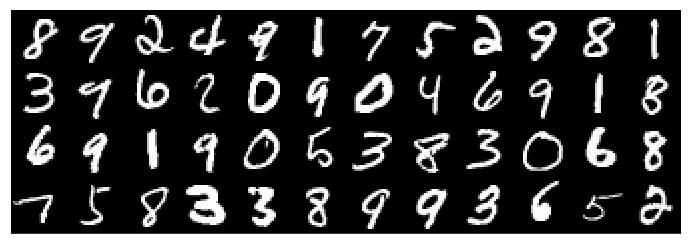

In [44]:
def make_big_picture(x, num_rows=4, num_cols=12):
        big_picture = (x[np.random.choice(range(x.shape[0]),num_rows)])
        big_picture = big_picture.reshape(-1,28)
        for col in range(num_cols-1):
            tmp = (x[np.random.choice(range(x.shape[0]),num_rows)])
            big_picture = np.hstack(tup=(tmp.reshape(-1,28), big_picture))
        return big_picture   

big_picture = make_big_picture(x)

plt.figure(figsize=(12,12))
plt.imshow(big_picture, cmap=plt.cm.gray)
plt.xticks([])
plt.yticks([]);

plt.savefig("pics/mnist_truth.png", bbox_inches='tight',  )

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        self.dr_rate = .2
        
        self.convT_1 = nn.ConvTranspose2d(in_channels=100,
                                            out_channels=256,
                                            kernel_size=(7,7),
                                            padding=0,
                                            output_padding=0,
                                            stride=1,
                                            bias=False)
        self.bn_1 = nn.BatchNorm2d(256)
        
        self.convT_2 = nn.ConvTranspose2d(in_channels=256,
                                            out_channels=128,
                                            kernel_size=5,
                                            padding=2,
                                            output_padding=1,
                                            stride=2,
                                            bias=True)
        
        self.convT_3 = nn.ConvTranspose2d(in_channels=128,
                                            out_channels=64,
                                            kernel_size=5,
                                            padding=2,
                                            output_padding=1,
                                            stride=2,
                                            bias=False)
        self.bn_3 = nn.BatchNorm2d(64)
        
        self.conv1 = nn.Conv2d(in_channels=64,
                                out_channels=1,
                                kernel_size=3,
                                padding=1,
                                stride=1,
                                bias=True)
        
    def forward(self, z):
        dropout = nn.Dropout(p=self.dr_rate)
        z = dropout(F.leaky_relu(self.convT_1(z), negative_slope=0.1))
        z = self.bn_1(z)
        
        z = dropout(F.leaky_relu(self.convT_2(z), negative_slope=0.1))
        
        z = F.leaky_relu(self.convT_3(z), negative_slope=0.1)
        z = self.bn_3(z)
        
        z = F.sigmoid(self.conv1(z))   
        return z
        
g = G()
g.cuda()

G(
  (convT_1): ConvTranspose2d (100, 256, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (bn_1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (convT_2): ConvTranspose2d (256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (convT_3): ConvTranspose2d (128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
  (bn_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (conv1): Conv2d (64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [58]:
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.dr_rate = 0.2
        
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=32, 
                               kernel_size=3, 
                               stride=2,
                               padding=1)
        
        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=64, 
                               kernel_size=3, 
                               stride=2,
                               padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=64,
                               out_channels=128, 
                               kernel_size=3, 
                               stride=2,
                               padding=1)
        
        self.fc1 = nn.Linear(in_features=128 * 4 * 4, 
                             out_features=512)
        
        self.fc2 = nn.Linear(in_features=512,
                             out_features=1)

    
    def dr_rate(self, dr_rate):
        self.dr_rate = dr_rate

    def forward(self, x):
        dropout = nn.Dropout(p=self.dr_rate)
        # Convolutional Part
        x = dropout(F.leaky_relu(self.conv1(x), negative_slope=.1))
        x = dropout(F.leaky_relu(self.conv2(x), negative_slope=.1))
        x = dropout(F.leaky_relu(self.conv3(x), negative_slope=.1))
        
        # Flatten
        x = x.view(-1, 128 * 4 * 4)
        # Dense Layers
        x = dropout(F.relu(self.fc1(x)))
        x = F.sigmoid(self.fc2(x))
        return x

d = D()
d.cuda()

D(
  (conv1): Conv2d (1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d (32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d (64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=512)
  (fc2): Linear(in_features=512, out_features=1)
)

In [59]:
criterion = nn.BCELoss()
d_optimizer = optim.Adam(d.parameters(), lr=0.0001)
g_optimizer = optim.Adam(g.parameters(), lr=0.0001)

In [60]:
batch_size = 16
num_steps = 10000

latent_size = 100

In [61]:
z_fixed_npy = np.random.normal(loc=0,scale=1, size=(1,latent_size,1,1)).astype(np.float32)

In [62]:
from tqdm import tqdm
for k in tqdm(range(num_steps)):
    d.zero_grad()
    
    # Train d on real
    x_train = x[np.random.randint(0, x.shape[0], batch_size)]
    x_train = Variable(torch.from_numpy(x_train).cuda())
    y_train = torch.ones(batch_size, 1)
    y_train = Variable(y_train.cuda())
    
    y_pred = d(x_train)
    d_loss = criterion(y_pred, y_train)
    d_loss.backward()
    
    # Train d on fake
    z = torch.Tensor(batch_size, latent_size, 1, 1).normal_(0, 1)
    z = Variable(z.cuda(), requires_grad=False)
    y_train = torch.zeros(batch_size, 1)
    y_train = Variable(y_train.cuda())
    
    x_train = g(z).detach()
    y_pred = d(x_train)
    d_loss = criterion(y_pred, y_train)
    d_loss.backward()
    
    d_optimizer.step()
    
    # Train g
    g.zero_grad()
    
    z = torch.Tensor(batch_size, latent_size, 1, 1).normal_(0, 1)
    z = Variable(z.cuda(), requires_grad=False)
    y_train = torch.ones(batch_size, 1)
    y_train = Variable(y_train.cuda())
    
    x_train = g(z)
    y_pred = d(x_train)
    g_loss = criterion(y_pred, y_train)
    g_loss.backward()  
    
    g_optimizer.step()
    
    if k%100 ==0:
        z_fixed = Variable(torch.from_numpy(z_fixed_npy).cuda(),requires_grad=False)
        out_fix = g(z_fixed)
        
        plt.imshow(out_fix.data[0,0],  cmap=plt.cm.gray)
        plt.xticks([])
        plt.yticks([])
        
        plt.savefig("mnist_progress//{}.png".format(k), bbox_inches='tight', dpi=200,)
        plt.close()


  0%|          | 199/100000 [00:03<32:46, 50.75it/s]
Exception in thread Thread-10:
Traceback (most recent call last):
  File "/mnt/fs2/home/alook/anaconda2/envs/torch/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/mnt/fs2/home/alook/anaconda2/envs/torch/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/mnt/fs2/home/alook/anaconda2/envs/torch/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  9%|▉         | 9446/100000 [02:58<28:32, 52.88it/s]


KeyboardInterrupt: 

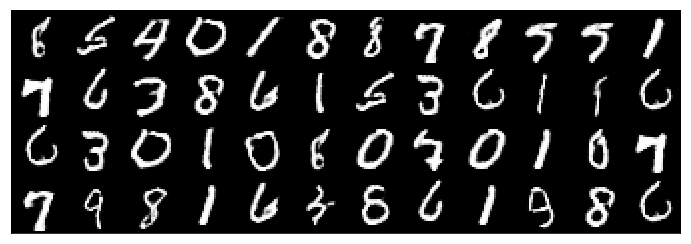

In [27]:
z = torch.Tensor(48, latent_size, 1, 1).normal_(0, 1)
z = Variable(z.cuda(), requires_grad=False)
y_train = torch.zeros(batch_size, 1)
y_train = Variable(y_train.cuda())

x_train = g(z).detach()

big_picture = make_big_picture(np.array(x_train.data))

plt.figure(figsize=(12,12))
plt.imshow(big_picture, cmap=plt.cm.gray)
plt.xticks([])
plt.yticks([]);

plt.savefig("pics/mnist_synthetic.png", bbox_inches='tight',)